In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import mlflow

from lib_dojo.pipeline import PipelineProfiler
from lib_dojo.utils import scatterplot_score_emissions, load_cleaned_carlab_data

# But du DOJO

Le but de ce TP va être de mesurer la consommation carbone du code que vous allez créer et de toutes les manipulations de données que vous allez effecuer. Pour cela, nous allons utiliser la librairie code carbon qui va chercher la consommation de votre CPU pour la traduire en émission carbone. Pour faire appel à cette librairie, vous trouverez deux snippets de code qui vous le permettent.

# Explications sur Code Carbon 

Code carbon est un package python qui permet de mesurer l'empreinte carbone associée à l'éxecution de code python. 

Son scope est limité aux émissions liées à l'utilisation de l'électricité par les composants cloud ou on-prem qui éxecutent le code. 

Les étapes du calcul : 
  * Estimation de l'efficacité énergétique (EE) 
    - Récupération de l'EE par le cloud provider si possible 
    - Sinon : 
      - Détection de la région (si l'étape échoue, on utilise une valeur de référence moyenne pour l'EE) 
      - Utlisation des api ElectricityMaps (si l'étape échoue, on utilise des valeurs de référence de la région) 
  * Mesure de la consommation d'électricité (CE)  
    - Détection du hardware pour avoir la puissance électrique 
    - Mesure du % d'utilisation 
  * Calcul de l'empreinte carbone 
    ## EC (CO2eq) = EE (CO₂eq/kWh) x CE (KWh)

## Méthode 1

In [2]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

""" insert your code here """

emissions: float = tracker.stop()

[codecarbon INFO @ 10:35:52] [setup] RAM Tracking...
[codecarbon INFO @ 10:35:52] [setup] GPU Tracking...
[codecarbon INFO @ 10:35:52] No GPU found.
[codecarbon INFO @ 10:35:52] [setup] CPU Tracking...
[codecarbon INFO @ 10:35:52] Tracking Intel CPU via Power Gadget
[codecarbon INFO @ 10:35:54] >>> Tracker's metadata:
[codecarbon INFO @ 10:35:54]   Platform system: macOS-14.5-x86_64-i386-64bit
[codecarbon INFO @ 10:35:54]   Python version: 3.12.2
[codecarbon INFO @ 10:35:54]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 10:35:54]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:35:54]   CPU count: 8
[codecarbon INFO @ 10:35:54]   CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
[codecarbon INFO @ 10:35:54]   GPU count: None
[codecarbon INFO @ 10:35:54]   GPU model: None
[codecarbon INFO @ 10:35:57] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

[codecarbon WARNING @ 10:35:57] Returncode while

## Méthode 2 

In [3]:
from codecarbon import track_emissions

@track_emissions(project_name='project_to_track', experiment_id=hash)
def function_to_track():

    """ Insert your code here """

    return

# Run function
function_to_track()

# Access emissions informations
pd.read_csv('./emissions.csv').tail(1)

[codecarbon INFO @ 10:35:57] [setup] RAM Tracking...
[codecarbon INFO @ 10:35:57] [setup] GPU Tracking...
[codecarbon INFO @ 10:35:57] No GPU found.
[codecarbon INFO @ 10:35:57] [setup] CPU Tracking...
[codecarbon INFO @ 10:35:57] Tracking Intel CPU via Power Gadget
[codecarbon INFO @ 10:35:59] >>> Tracker's metadata:
[codecarbon INFO @ 10:35:59]   Platform system: macOS-14.5-x86_64-i386-64bit
[codecarbon INFO @ 10:35:59]   Python version: 3.12.2
[codecarbon INFO @ 10:35:59]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 10:35:59]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:35:59]   CPU count: 8
[codecarbon INFO @ 10:35:59]   CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz
[codecarbon INFO @ 10:35:59]   GPU count: None
[codecarbon INFO @ 10:35:59]   GPU model: None
[codecarbon INFO @ 10:36:00] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 10:36:00] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
ERROR: Failed

timestamp      project_name  \
5  2024-05-21T10:36:01  project_to_track   

                                 run_id  duration     emissions  \
5  b6dd1d34-d48c-4527-ade4-f0ca96ac004a  0.304431  1.508426e-10   

   emissions_rate  cpu_power  gpu_power  ram_power  cpu_energy  ...  \
5    4.954904e-10        0.0        0.0        6.0         0.0  ...   

   cpu_count                                 cpu_model  gpu_count gpu_model  \
5          8  Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz        NaN       NaN   

  longitude latitude  ram_total_size  tracking_mode on_cloud  pue  
5    2.3965  48.6735            16.0        machine        N  1.0  

[1 rows x 31 columns]

# Explications sur l'objet PipelineProfiler utlisé pendant le tp 

La classe PipelineProfiler créée pour le DOJO sert à simplifier la création, l'entrainement et l'évaluation de modèles sklearn avec des mesures d'empreinte carbone pour les différentes étapes.

Cela permet une granularité dans cette mesure à la maille d'étape (au sens de la pipeline sklearn). 

# Import des données et préparation rapide

In [4]:
df = load_cleaned_carlab_data(data_path="../data")

**Description officielle des colonnes**

nom-colonne typerubrique  longueur  \
0      lib_mrq_utac      varchar        12   
1           hybride      varchar         3   
2    puiss_admin_98        varnb         2   
3         puiss_max        varnb        11   
4       conso_mixte        varnb        11   
5               co2        varnb         3   
6          co_typ_1        varnb        11   
7             hcnox        varnb        11   
8              ptcl        varnb         5   
9   masse_ordma_min        varnb         4   
10            gamme      varchar        14   

                                              légende              unité  
0                                           la marque                NaN  
1   une information permettant d’identifier les vé...                NaN  
2                         la puissance administrative                NaN  
3                       la puissance maximale (en kW)                 kW  
4   consommation extra urbaine de carburant (en l/...  litre pour 100 km  
5                        l'émission de CO2 (en g/km),      gramme par km  
6                    le résultat d’essai de CO type I      gramme par km  
7                        les résultats d’essai HC+NOX      gramme par km  
8                  le résultat d’essai de particules       gramme par km  
9                    la masse en ordre de marche mini                 kg  
10                                              gamme                NaN

**DataFrame head:**

hybride  puiss_admin_98  puiss_max  conso_mixte    co2  co_typ_1  hcnox  \
0     non              12      147.0          7.8  182.0     0.647    NaN   
1     non              12      147.0          8.0  186.0     0.647    NaN   
2     non               7      100.0          5.1  134.0     0.066  0.175   
3     non               7      100.0          5.1  134.0     0.066  0.175   
4     non               9      125.0          5.3  139.0     0.060  0.193   

    ptcl  masse_ordma_min      gamme typ_boite  nb_rapp  
0  0.002             1505  MOY-SUPER         M        6  
1  0.002             1555  MOY-SUPER         M        6  
2  0.001             1565  MOY-SUPER         M        6  
3  0.001             1565  MOY-SUPER         M        6  
4  0.001             1565  MOY-SUPER         M        6

**DataFrame shape: (55044, 12)**

## Colonnes disponibles

In [5]:
class DatasetColumns:
    hybride = "hybride"
    ptcl = "ptcl"
    typ_boite = "typ_boite"
    puiss_admin_98 = "puiss_admin_98"
    puiss_max = "puiss_max"
    nb_rapp = "nb_rapp"
    conso_mixte = "conso_mixte"
    co2 = "co2"
    co_typ_1 = "co_typ_1"
    hcnox = "hcnox"
    masse_ordma_min = "masse_ordma_min"

    categorical_features = [hybride, ptcl, typ_boite]

    numerical_features = [
        puiss_admin_98, puiss_max, nb_rapp, conso_mixte, co2, co_typ_1, hcnox, ptcl, masse_ordma_min,
    ]

    columns_to_impute = [conso_mixte, co2, co_typ_1, hcnox, ptcl]


# Définition des objets utilisés pendant le DOJO

In [6]:
preprocessor = ColumnTransformer(
    [
        (
            "One hot encoding",
            OneHotEncoder(
                handle_unknown="ignore", drop="if_binary", sparse_output=False
            ),
            DatasetColumns.categorical_features,
        ),
        ("minmax", MinMaxScaler(), DatasetColumns.numerical_features),
    ],
    remainder="passthrough",
)

In [7]:
simple_imputer = SimpleImputer(strategy="mean")

In [8]:
simple_model = LogisticRegression()

# Première Pipeline Simple

In [9]:
Lr_pipeline = PipelineProfiler(
    data=df,
    imputer=simple_imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target="gamme",
    sampling_strategy=None,
    feature_selection=None,
    model=simple_model,
    search_method="none",
)

### Entrainement

In [10]:
Lr_pipeline.fit()

Splitting data...
Imputing data...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Preprocessing data...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



No oversampling performed
Data preprocessed.
Fitting model...
Model fitted.


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



{'model': LogisticRegression(),
 'impute_emissions': 1.7590985655784608e-06,
 'preprocessing_emissions': 8.971266114711761e-06,
 'fitting_emissions': 0.00021727857091029484}

### Inférence

In [11]:
Lr_pipeline.predict()

Predicting...
here is X shape :  (11009, 11)


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Prediction done.


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



(array(['LUXE', 'MOY-SUPER', 'MOY-INFER', ..., 'MOY-SUPER', 'MOY-INFER',
        'MOY-INFER'], dtype=object),
 {'impute_emissions': 8.822672883669536e-07,
  'preprocessing_emissions': 2.953146533171336e-06,
  'fitting_emissions': 3.1132544676462815e-07})

### Performance du modèle

In [12]:
f1_score = Lr_pipeline.score(metric="f1")
print(f1_score)

0.720918517103065


In [13]:
preprocessor_training_emissions = Lr_pipeline.train_preprocessing_emissions
preprocessor_prediction_emissions = Lr_pipeline.inference_preprocessing_emissions
preprocessor_score = Lr_pipeline.score()

In [14]:
preprocessor = ColumnTransformer(
    [
        (
            "One hot encoding",
            OneHotEncoder(
                handle_unknown="ignore", drop="if_binary", sparse_output=False
            ),
            DatasetColumns.categorical_features,
        ),
    ],
    remainder="passthrough",
)

Lr_pipeline = PipelineProfiler(
    data=df,
    imputer=simple_imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target="gamme",
    sampling_strategy=None,
    feature_selection=None,
    model=simple_model,
    search_method="none",
)

Lr_pipeline.fit()

Splitting data...
Imputing data...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Preprocessing data...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



No oversampling performed
Data preprocessed.
Fitting model...
Model fitted.


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



{'model': LogisticRegression(),
 'impute_emissions': 2.1491792281468714e-06,
 'preprocessing_emissions': 7.871263817946116e-06,
 'fitting_emissions': 0.0002449984788298607}

In [15]:
no_preprocessor_score = Lr_pipeline.score()
no_preprocessor_training_emissions = Lr_pipeline.train_preprocessing_emissions
no_preprocessor_prediction_emissions = Lr_pipeline.inference_preprocessing_emissions

Predicting...
here is X shape :  (11009, 11)


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Prediction done.


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



In [16]:
preprocessor_dict = {
    'MinMaxScaler': {
        'train': preprocessor_training_emissions,
        'inference': preprocessor_prediction_emissions,
        'score': preprocessor_score
    },
    'None': {
        'train': no_preprocessor_training_emissions,
        'inference': no_preprocessor_prediction_emissions,
        'score': no_preprocessor_score
    }
}

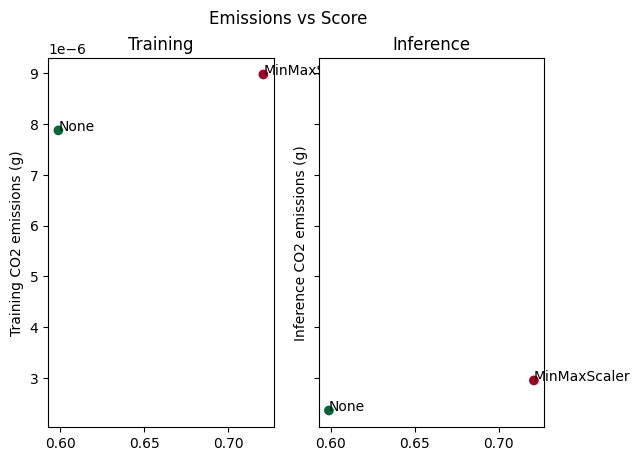

In [17]:
scatterplot_score_emissions(preprocessor_dict)

### Intégration à MLFlow pour faire du tracking d'expérimentations

In [13]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "simple imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "logistic regression")
    mlflow.log_param("search method", "none")
    mlflow.log_metric("f1 score", f1_score)
    mlflow.log_metric("train emissions", Lr_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", Lr_pipeline.inference_total_emissions)

2024/04/22 00:53:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/22 00:53:34 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

# Focus sur l'imputation de données manquantes

In [14]:
simple_imputer = SimpleImputer(strategy="mean")
iterative_imputer = IterativeImputer(max_iter=20)
# knn_imputer = KNNImputer()

In [15]:
imputing_dict = {
    "Simple": {"train": 0, "inference": 0, "score": 0},
    "Iterative": {"train": 0, "inference": 0, "score": 0}
}

### Vous pouvez ici vous servir des méthodes impute_data() / fit() et set_imputer() afin de comparer l'impact de ce dernier sur le co2 dégagé ainsi que la performance.

In [16]:
impute_pipeline = PipelineProfiler(
    data=df,
    imputer=simple_imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target="gamme",
    sampling_strategy=None,
    feature_selection=None,
    model=simple_model,
    search_method="none",
)

impute_pipeline.fit()

Splitting data...
Imputing data...
Preprocessing data...
No oversampling performed
Data preprocessed.
Fitting model...
Model fitted.


{'model': LogisticRegression(),
 'impute_emissions': 8.925655298110783e-06,
 'preprocessing_emissions': 5.11480467968754e-05,
 'fitting_emissions': 0.011689149330722487}

In [17]:
imputing_dict["Simple"]["train"] = impute_pipeline.train_impute_emissions
imputing_dict["Simple"]["score"] = impute_pipeline.score(metric="f1")
imputing_dict["Simple"]["inference"] = impute_pipeline.inference_impute_emissions

Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [18]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "simple imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "logistic regression")
    mlflow.log_param("search method", "none")
    mlflow.log_metric("f1 score", imputing_dict["Simple"]["score"])
    mlflow.log_metric("train emissions", impute_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", impute_pipeline.inference_total_emissions)

In [19]:
impute_pipeline.set_imputer(iterative_imputer)

impute_pipeline.fit()

Splitting data...
Imputing data...
Preprocessing data...
No oversampling performed
Data preprocessed.
Fitting model...
Model fitted.


{'model': LogisticRegression(),
 'impute_emissions': 0.0010045727600319079,
 'preprocessing_emissions': 0.0002775936462896365,
 'fitting_emissions': 0.041332782366642985}

In [20]:
imputing_dict["Iterative"]["train"] = impute_pipeline.train_impute_emissions
imputing_dict["Iterative"]["score"] = impute_pipeline.score(metric="f1")
imputing_dict["Iterative"]["inference"] = impute_pipeline.inference_impute_emissions

Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [21]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "Iterative imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "logistic regression")
    mlflow.log_param("search method", "none")
    mlflow.log_metric("f1 score", imputing_dict["Iterative"]["score"])
    mlflow.log_metric("train emissions", impute_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", impute_pipeline.inference_total_emissions)

### Comparaison des résultats

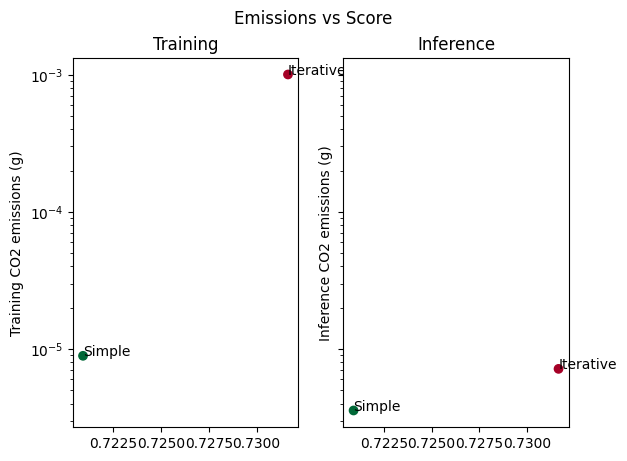

In [22]:
scatterplot_score_emissions(imputing_dict, log_scale=True)

# Focus sur la sélection de features

Nous vous proposons de tester divers arguments pour la sélection de variable. Elle se base pour le moment sur un Sequential Forward Feature Selection et est régie par un booléen feature_selection. 
Si feature_selection est True, vous pouvez alors choisir le classifier à utiliser ainsi qu'un tuple [min, max] du nombre de features que doit retourner le sélecteur.


In [14]:
n_features = [5, 15, 25]
fs_dict = {}

for i, k in enumerate(n_features):
    print(i)
    selector = SelectKBest(score_func=f_classif, k=k)
    feature_pipeline = PipelineProfiler(
        data=df,
        imputer=simple_imputer,
        preprocessor=preprocessor,
        cols_to_impute=DatasetColumns.columns_to_impute,
        target='gamme',
        sampling_strategy=None,
        feature_selection=True,
        selector=selector,
        model=simple_model,
        search_method="none"
    )
    feature_pipeline.fit()
    feature_pipeline.predict()
    f1_score = feature_pipeline.score(metric="f1")
    feature_pipeline.reset()

    fs_dict[n_features[i]] = {
        "train": feature_pipeline.train_emissions,
        "score": f1_score,
        "inference": feature_pipeline.inference_emissions
}




0
Splitting data...
Imputing data...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Preprocessing data...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

No oversampling performed
Data preprocessed.
Fitting model...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Prediction done.
1
Splitting data...
Imputing data...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Preprocessing data...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

No oversampling performed
Data preprocessed.
Fitting model...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Prediction done.
2
Splitting data...
Imputing data...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Preprocessing data...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

No oversampling performed
Data preprocessed.
Fitting model...


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMet

Prediction done.


ERROR: getMetric_powerMetric -- metric is NULL
ERROR: getMetric_powerMetric -- metric is NULL


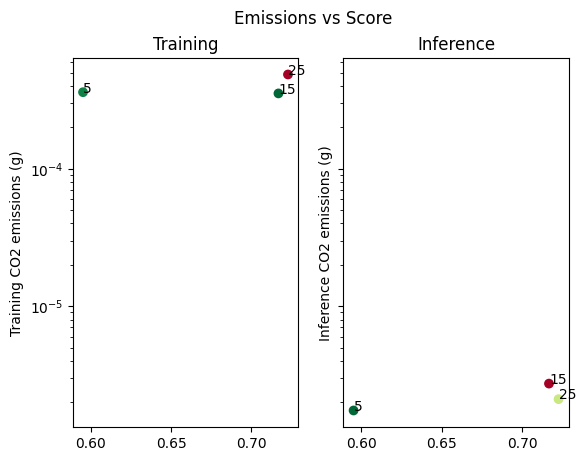

In [16]:
scatterplot_score_emissions(fs_dict, log_scale=True)

# Focus sur le choix de l'algorithme

In [19]:
models = [LogisticRegression(), RandomForestClassifier(), MLPClassifier(), SVC()]
models_names = ["Log Reg", "RForest", "MLP", "SVC"]
models_pipeline = PipelineProfiler(
    data=df,
    imputer=simple_imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target="gamme",
    sampling_strategy=None,
    model=models[0],
    search_method="none"
)
models_dict = {}

In [20]:
for i, model in enumerate(models):
    models_pipeline.set_model(model)
    models_pipeline.fit()
    models_pipeline.predict()
    f1_score = models_pipeline.score(metric="f1")
    with mlflow.start_run():
        mlflow.log_param("Imputer", "Simple imputer")
        mlflow.log_param("Preprocessor", "one hot and minmax")
        mlflow.log_param("feature selection", "none")
        mlflow.log_param("algo", models_names[i])
        mlflow.log_param("search method", "none")
        mlflow.log_metric("f1 score", f1_score)
        mlflow.log_metric("train emissions", models_pipeline.train_total_emissions)
        mlflow.log_metric("inference emissions", models_pipeline.inference_total_emissions)

    models_dict[models_names[i]] = {
        "train": models_pipeline.train_total_emissions,
        "score": f1_score,
        "inference": models_pipeline.inference_total_emissions,
    }
    models_pipeline.reset()

Splitting data...
Imputing data...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Preprocessing data...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



No oversampling performed
Data preprocessed.
Fitting model...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Prediction done.
Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Prediction done.
Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Prediction done.
Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_i

Model fitted.
Predicting...
here is X shape :  (11009, 11)


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Prediction done.


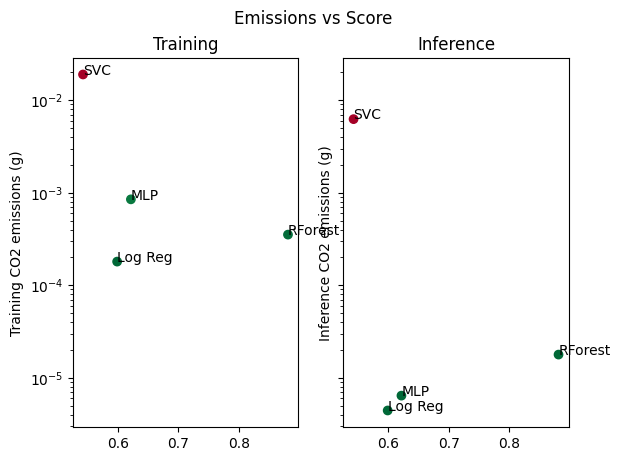

In [21]:
scatterplot_score_emissions(models_dict, log_scale=True)

# Focus sur le tuning d'hyperparamètres

In [27]:
simple_model = LogisticRegression()
lr_hp = {"C": [0.1, 10, 100], "max_iter": [20, 50], "solver": ["liblinear", "lbfgs"], "penalty":["l1", "l2"]}

complex_model = RandomForestClassifier()
rf_hp = {"n_estimators": [100, 500], "max_depth": [5, 20]}

hp_dict = {
    "LR_grid": {"train": 0, "inference": 0, "score": 0},
    "RF_grid": {"train": 0, "inference": 0, "score": 0},
    "LR_rand": {"train": 0, "inference": 0, "score": 0},
    "RF_rand": {"train": 0, "inference": 0, "score": 0},
}

In [28]:
hp_pipeline = PipelineProfiler(
    data=df,
    imputer=simple_imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target="gamme",
    sampling_strategy=None,
    model=simple_model,
    search_method="grid",
    param_grid=lr_hp,
)

In [29]:
hp_pipeline.fit()
hp_pipeline.predict()

hp_dict["LR_grid"]["train"] = hp_pipeline.train_emissions
hp_dict["LR_grid"]["score"] = hp_pipeline.score(metric="f1")
hp_dict["LR_grid"]["inference"] = hp_pipeline.inference_emissions

Splitting data...
Imputing data...
Preprocessing data...
No oversampling performed
Data preprocessed.
Fitting model...
Model fitted.
Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [30]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "Simple imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "Logistic Regression")
    mlflow.log_param("search method", "grid")
    mlflow.log_metric("f1 score", hp_dict["LR_grid"]["score"])
    mlflow.log_metric("train emissions", hp_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", hp_pipeline.inference_total_emissions)

In [31]:
hp_pipeline.set_search_method("random")
hp_pipeline.fit()
hp_pipeline.predict()

hp_dict["LR_rand"]["train"] = hp_pipeline.train_emissions
hp_dict["LR_rand"]["score"] = hp_pipeline.score(metric="f1")
hp_dict["LR_rand"]["inference"] = hp_pipeline.inference_emissions

Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...
Model fitted.
Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [32]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "Simple imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "Logistic Regression")
    mlflow.log_param("search method", "random")
    mlflow.log_metric("f1 score", hp_dict["LR_grid"]["score"])
    mlflow.log_metric("train emissions", hp_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", hp_pipeline.inference_total_emissions)

In [33]:
hp_pipeline.set_model(complex_model)
hp_pipeline.set_param_grid(rf_hp)
hp_pipeline.set_search_method("grid")

hp_pipeline.fit()
hp_dict["RF_grid"]["train"] = hp_pipeline.train_emissions
hp_dict["RF_grid"]["score"] = hp_pipeline.score(metric="f1")
hp_dict["RF_grid"]["inference"] = hp_pipeline.inference_emissions

Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...
Model fitted.
Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [34]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "Simple imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "Random Forest")
    mlflow.log_param("search method", "grid")
    mlflow.log_metric("f1 score", hp_dict["RF_grid"]["score"])
    mlflow.log_metric("train emissions", hp_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", hp_pipeline.inference_total_emissions)

In [35]:
hp_pipeline.set_search_method("random")
hp_pipeline.fit()
hp_pipeline.predict()

hp_dict["RF_rand"]["train"] = hp_pipeline.train_emissions
hp_dict["RF_rand"]["score"] = hp_pipeline.score(metric="f1")
hp_dict["RF_rand"]["inference"] = hp_pipeline.inference_emissions

Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...
Model fitted.
Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [36]:
with mlflow.start_run():
    mlflow.log_param("Imputer", "Simple imputer")
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", "Random Forest")
    mlflow.log_param("search method", "random")
    mlflow.log_metric("f1 score", hp_dict["RF_rand"]["score"])
    mlflow.log_metric("train emissions", hp_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", hp_pipeline.inference_total_emissions)

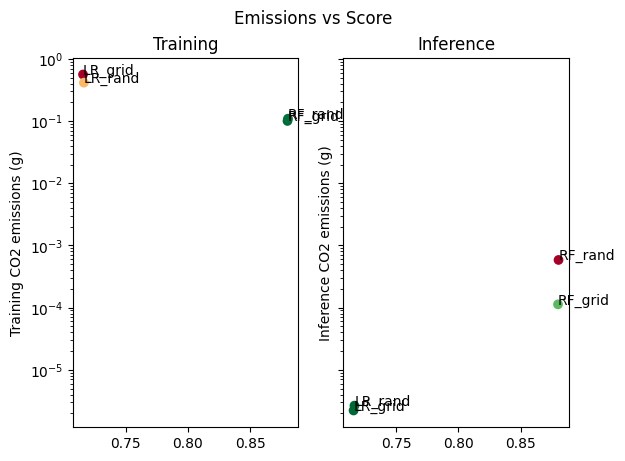

In [37]:
scatterplot_score_emissions(hp_dict, log_scale=True)

# A votre tour : Hackathon pour trouver le meilleur compromis performance du modèle / Coût Carbon

In [ ]:
hackaton_imputer = #TODO
hackaton_model = #TODO
hackaton_search_method = #TODO
hackaton_hp = {}

hackaton_pipeline = PipelineProfiler(
    data=df,
    imputer=hackaton_imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target='gamme',
    sampling_strategy=None,
    model=hackaton_model,
    search_method=hackaton_search_method,
    param_grid=hackaton_hp
)

In [ ]:
with mlflow.start_run():
    mlflow.log_param("Imputer", #TODO)
    mlflow.log_param("Preprocessor", "one hot and minmax")
    mlflow.log_param("feature selection", "none")
    mlflow.log_param("algo", #TODO)
    mlflow.log_param("search method", #TODO)
    mlflow.log_metric("f1 score", #TODO)
    mlflow.log_metric("train emissions", hackaton_pipeline.train_total_emissions)
    mlflow.log_metric("inference emissions", hackaton_pipeline.inference_total_emissions)